In [ ]:
# get data from udacity
import requests, zipfile, io, pickle

r = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))

train = pickle.load(z.open('train.p'))
test = pickle.load(z.open('test.p'))
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
# Number of training examples
n_train = len(X_train) 

# Number of testing examples.
n_test = len(X_test) 

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape 

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train)) #set() returns unordered collection of unique elements

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


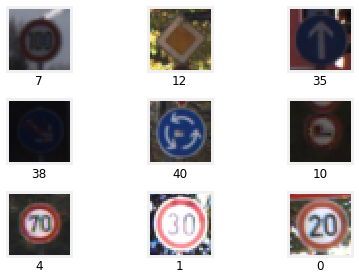

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

#make a grid
fig, ax= plt.subplots(nrows=3, ncols=3)
fig.tight_layout()
flat = [axis for row in ax for axis in row]

#hide the messy ticks 
for axis in flat:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.tick1On = axis.tick2On = False
    axis.label1On = axis.label2On = False

#include the image and the label
for i in range(3):
    for j in range(3):
        index = random.randint(0,len(X_train))
        img = X_train[index]
        class_id = y_train[index]
        ax[i][j].set_xlabel(class_id)
        ax[i][j].imshow(img)

plt.show()

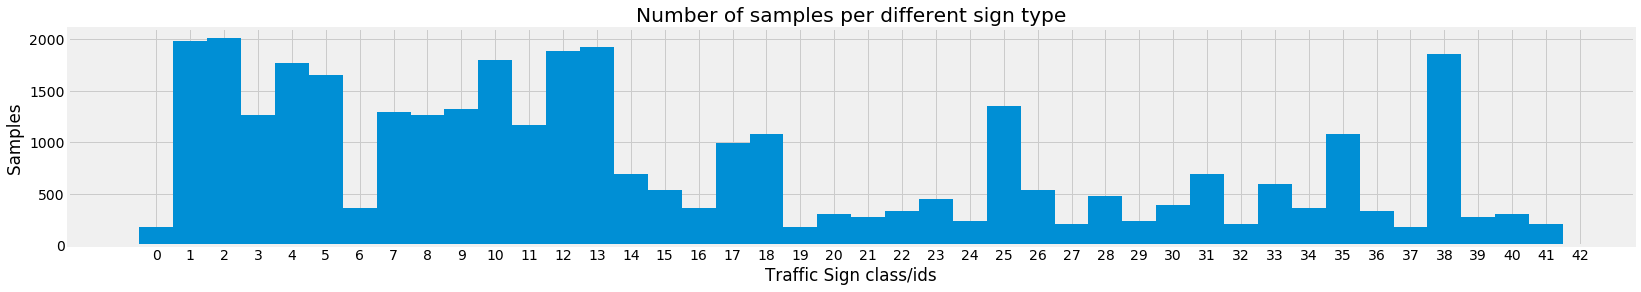

In [ ]:
def make_barchart(labels, string):
    samples_per_class = np.bincount(labels)
    x_tix = range(43)
    bins = np.arange(43) - 0.5
    fig = plt.figure(figsize=(25,4))
    plt.style.use('fivethirtyeight')
    ax1 = fig.add_subplot(1,1,1)
    plt.hist(y_train,bins)
    plt.title("Number of samples per different sign type" + string, loc='center')  
    plt.xlabel("Traffic Sign class/ids"); plt.ylabel("Samples ")
    plt.xticks(np.arange(min(x_tix), max(x_tix)+1, 1.0))
    plt.show();
    
make_barchart(y_train, "");

In [ ]:
import pandas as pd

names_ids = pd.read_csv('signnames.csv')
names_ids.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [ ]:
import cv2

#TODO: fix this
#http://stackoverflow.com/questions/15007304/histogram-equalization-not-working-on-color-image-opencv
# def histogram_equalization(img_array):
#     for i in range(len(img_array)):
#         img_yuv = cv2.cvtColor(img_array[i], cv2.COLOR_BGR2YUV)
#         img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
#         img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     return img_output

#normalizing pixel values [0,1]. 
#TODO:Could aslo normalize from [-1,1] 
#see how this effects TRAINING score (not test score!! no cheating!)
def normalize(img):
    img_array = np.asarray(img)
    normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())
    return normalized

# X_train = histogram_equalization(X_train)
# X_test = histogram_equalization(X_test)

X_train = normalize(X_train)
X_test = normalize(X_test)


In [ ]:
from sklearn.model_selection import train_test_split

#stratify param ensures same distribution of labels. important since there is a high variance in number of samples per label
#histograms of the new split sets will be the very, very similiar to the original set
X_train_split, X_validate_split, y_train_split, y_validate_split = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=666, 
                                                    stratify=y_train)

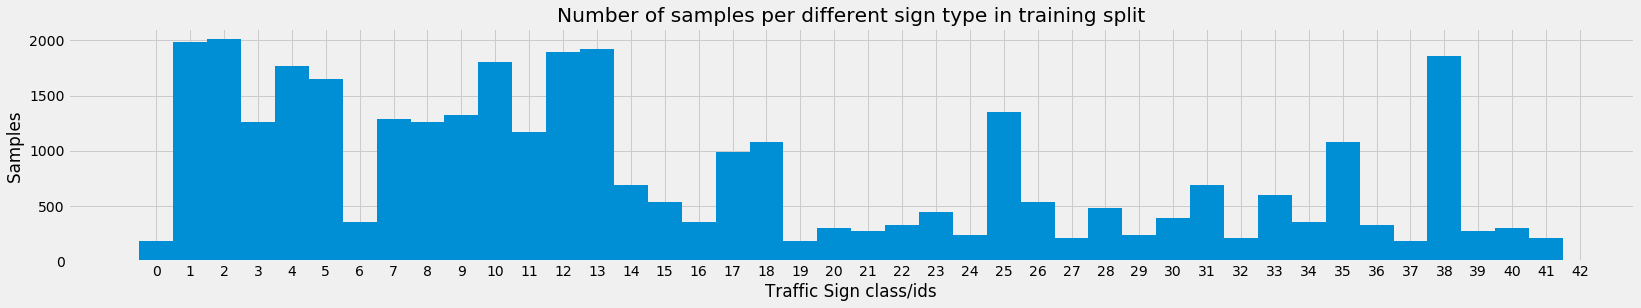

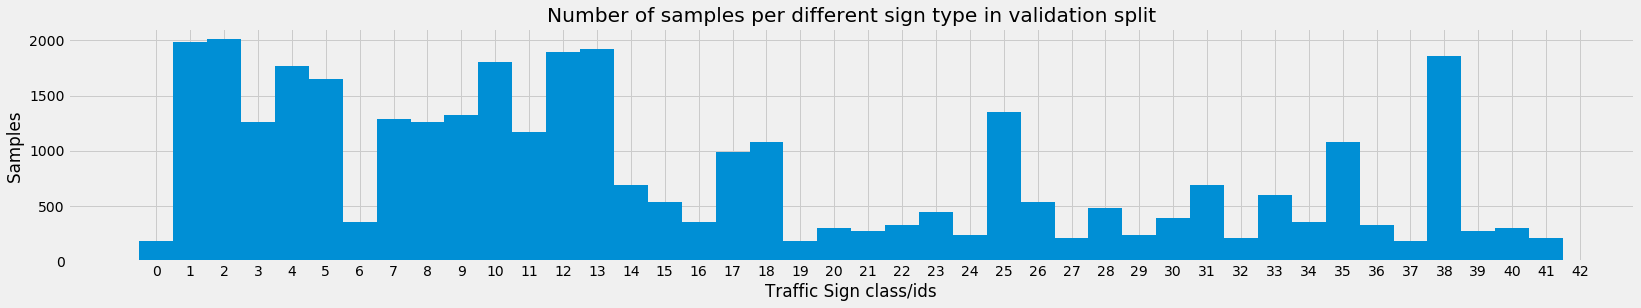

In [ ]:
#training split
make_barchart(y_train_split, " in training split")

#validation split
make_barchart(y_validate_split, " in validation split")

In [ ]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
X_validate_split, y_validate_split = shuffle(X_validate_split, y_validate_split)

EPOCHS = 150
BATCH_SIZE = 128
LEARNING_RATE = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

#added after initial training in order to retrieve collection for testing new data in part 7
tf.add_to_collection('x', x)
tf.add_to_collection('y', y)
tf.add_to_collection('keep_prob', keep_prob)

In [ ]:
#create one hot encoding of possible classes
one_hot_y = tf.one_hot(y, 43)

In [ ]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    #Conv / ReLU / Max Pool
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Conv / ReLU / Max Pool
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    fc0 =  flatten(conv2)
       
    # Fully Connected / ReLu / Dropout
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

    # Fully Connected / ReLu / Dropout
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024,512), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(512))
    fc2 = tf.matmul(fc1_drop, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2_drop = tf.nn.dropout(fc2, keep_prob)

    # Fully Connected 
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    weights = [conv1_W,conv2_W,fc1_W,fc2_W,fc3_W]
    
    #added after initial training in order to retrieve collection for testing new data in part 7
    tf.add_to_collection('logits', logits)
    
    return logits,weights

In [ ]:
logits,weights = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)

# L2 Regularization 
regularizers = 0.0
for w in weights:
    regularizers += tf.nn.l2_loss(w)

In [ ]:
# See notes below on l2 params
#http://docs.aws.amazon.com/machine-learning/latest/dg/training-parameters.html
L2_strength = 1e-6
loss_operation = tf.reduce_mean(cross_entropy) + L2_strength * regularizers
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#added after initial training in order to retrieve collection for testing new data in part 7
tf.add_to_collection('accuracy_operation', accuracy_operation)


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples,total_loss / num_examples

In [ ]:
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.per_process_gpu_memory_fraction=0.3

In [ ]:
import os

save_dir = './model'

In [ ]:
with tf.device('/gpu:0'):
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_split)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_split[offset:end], y_train_split[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            training_accuracy,training_loss = evaluate(X_train_split, y_train_split)
            validation_accuracy,validation_loss = evaluate(X_validate_split, y_validate_split)

            if i%10 == 0:
                print("EPOCH {} ...".format(i))
                print("Training Accuracy = {:.4f} Validation Accuracy = {:.4f}".format(training_accuracy,validation_accuracy))
                print("Training Loss = {:.4f} Validation Loss = {:.4f}".format(training_loss,validation_loss))
                print()

        saver = tf.train.Saver()
        path = os.path.join(save_dir, 'lenet_traffic_classifier')
        saver.save(sess, path)
        print("Model saved")

Training...

EPOCH 0 ...
Training Accuracy = 0.9024 Validation Accuracy = 0.8938
Training Loss = 0.4184 Validation Loss = 0.4499

EPOCH 10 ...
Training Accuracy = 0.9993 Validation Accuracy = 0.9943
Training Loss = 0.0123 Validation Loss = 0.0374

EPOCH 20 ...
Training Accuracy = 0.9976 Validation Accuracy = 0.9914
Training Loss = 0.0195 Validation Loss = 0.0635

EPOCH 30 ...
Training Accuracy = 0.9998 Validation Accuracy = 0.9937
Training Loss = 0.0120 Validation Loss = 0.0506

EPOCH 40 ...
Training Accuracy = 0.9989 Validation Accuracy = 0.9924
Training Loss = 0.0161 Validation Loss = 0.0555

EPOCH 50 ...
Training Accuracy = 0.9999 Validation Accuracy = 0.9951
Training Loss = 0.0127 Validation Loss = 0.0464

EPOCH 60 ...
Training Accuracy = 0.9997 Validation Accuracy = 0.9941
Training Loss = 0.0139 Validation Loss = 0.0546

EPOCH 70 ...
Training Accuracy = 0.9995 Validation Accuracy = 0.9934
Training Loss = 0.0153 Validation Loss = 0.0753

EPOCH 80 ...
Training Accuracy = 1.0000 Vali

In [ ]:
#run model on testing sample
#tf.saver will not run on the GPU so have to soft_place the cpu device
with tf.device('/cpu:0'):
    with tf.Session(config=config) as sess:
        loader = tf.train.import_meta_graph('lenet_traffic_classifier.meta')
        loader.restore(sess, tf.train.latest_checkpoint(save_dir))

        X_test = normalize(X_test)

        test_accuracy,test_loss = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model/lenet_traffic_classifier
Test Accuracy = 0.956
